In [1]:
import os
#from osgeo import gdal
import geopandas as gpd

import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.processing.select import select_point
from valenspy.diagnostic.functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic.visualizations import *
from valenspy.processing.regrid import *
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import percentileofscore
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.cm
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray as rio

manager = vp.InputManager(machine="hortense")

In [2]:
cclm_var = "T_2M"
start_date = "20190722"
end_date = "20190726"


In [3]:
ucl_dir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/'
cclm_dir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/'
gridfile = manager._get_file_paths("ERA5-Land","tas", period=[1995,1995],freq="hourly",region="belgium")[0]


## 1. Loading CCLM data during HW period

In [4]:
cclm_files = os.listdir(cclm_dir + 'daily/')
year = pd.to_datetime(start_date).year
cclm_files = [i for i in cclm_files if str(year)  in i]
cclm_min = [cclm_dir + 'daily/' + i for i in cclm_files if 'min' in i]
cclm_max = [cclm_dir  + 'daily/'+ i for i in cclm_files if 'max' in i]
cclm_mean = [cclm_dir  + 'daily/'+ i for i in cclm_files if 'mean' in i]

daily_min =  xr.open_mfdataset(cclm_min, combine='by_coords')
daily_mean =  xr.open_mfdataset(cclm_mean, combine='by_coords')
daily_max =  xr.open_mfdataset(cclm_max, combine='by_coords')
case_max = daily_max.sel(time=slice(start_date, end_date))
case_mean = daily_mean.sel(time=slice(start_date, end_date))
case_min = daily_min.sel(time=slice(start_date, end_date))

In [5]:
cclm_files

['T_2M_daily_min_2019.nc', 'T_2M_daily_mean_2019.nc', 'T_2M_daily_max_2019.nc']

In [6]:
# case_max = remap_cdo(gridfile, case_max, remap_method = "con")
# case_min = remap_cdo(gridfile, case_min, remap_method = "con")
# case_mean = remap_cdo(gridfile, case_mean, remap_method = "con")
case_diff = case_max[cclm_var]-case_min[cclm_var]
case_diff = case_diff.mean('time')
case_mean = case_mean[cclm_var].mean("time")

AttributeError: Rectangle.set() got an unexpected keyword argument 'cbar_kwargs'

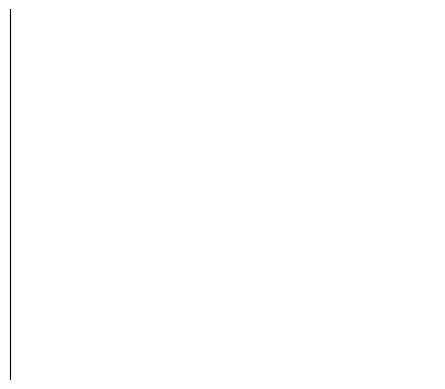

In [7]:
p1 = plot_map(case_max[cclm_var])
p2 = plot_map(case_min[cclm_var])


In [8]:
period = pd.date_range(start = start_date, end = end_date)
period  = period.strftime('%Y-%m-%d').str.replace('-', '')
hourly_files = [cclm_dir + 'hourly/' + cclm_var + '_hourly_' + i + '.nc' for i in period]
hourly_files

['/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/hourly/T_2M_hourly_20190722.nc',
 '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/hourly/T_2M_hourly_20190723.nc',
 '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/hourly/T_2M_hourly_20190724.nc',
 '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/hourly/T_2M_hourly_20190725.nc',
 '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/hourly/T_2M_hourly_20190726.nc']

In [9]:
hourly_data = xr.open_mfdataset(hourly_files, combine='by_coords')
hourly_data

<xarray.Dataset> Size: 41MB
Dimensions:       (time: 120, bnds: 2, rlat: 320, rlon: 260)
Coordinates:
  * time          (time) datetime64[ns] 960B 2019-07-22 ... 2019-07-26T23:00:00
    lon           (rlat, rlon) float32 333kB dask.array<chunksize=(320, 260), meta=np.ndarray>
    lat           (rlat, rlon) float32 333kB dask.array<chunksize=(320, 260), meta=np.ndarray>
  * rlon          (rlon) float32 1kB -3.263 -3.237 -3.213 ... 3.162 3.188 3.213
  * rlat          (rlat) float32 1kB -4.012 -3.987 -3.963 ... 3.912 3.938 3.963
    height_2m     float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 2kB dask.array<chunksize=(24, 2), meta=np.ndarray>
    rotated_pole  (time) |S1 120B b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    T_2M          (time, rlat, rlon) float32 40MB dask.array<chunksize=(24, 320, 260), meta=np.ndarray>
Attributes: (12/14)
    CDI:             Climate Data Interface version 2.3.0 (https://mpimet.mpg...
    Conventions:     CF-1.4
    source:          cosmo6.00_clm2, int2lm3.0_clm1
    institution:     KU Leuven, Leuven, BELGIUM
    title:           BE_28 Ecoclimap Nukleus Transient
    project_id:      CORDEXbe2
    ...              ...
    conventionsURL:  http://www.cfconventions.org/
    contact:         FIEN SERRAS (fien.serras@kuleuven.be)
    references:      http://ees.kuleuven.be/rcs/
    creation_date:   2024-12-03 22:59:44
    history:         Thu Jan 02 17:56:20 2025: cdo mergetime hourly/temp/T_2M...
    CDO:             Climate Data Operators version 2.3.0 (https://mpimet.mpg...

In [10]:
P75 = hourly_data[cclm_var].chunk({"time": -1}).quantile(q = 0.75, dim = "time")
P25 = hourly_data[cclm_var].chunk({"time": -1}).quantile(q = 0.25, dim = "time")
CD = (P75-P25)/(P75+P25)
IQR = P75-P25
stdev = hourly_data[cclm_var].std(dim = "time")
cv = case_mean/stdev
P90 = hourly_data[cclm_var].chunk({"time": -1}).quantile(q = 0.90, dim = "time")
PVR = P90/stdev


In [19]:
plot_data = case_mean/case_diff
cv = cv.where(cv <= 40)

In [12]:
rp_lat = float(hourly_data.rotated_pole.grid_north_pole_latitude)
rp_lon = float(hourly_data.rotated_pole.grid_north_pole_longitude)
rp = ccrs.RotatedPole(pole_longitude=rp_lon, pole_latitude=rp_lat)


/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/conda_envs/wrf_env/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


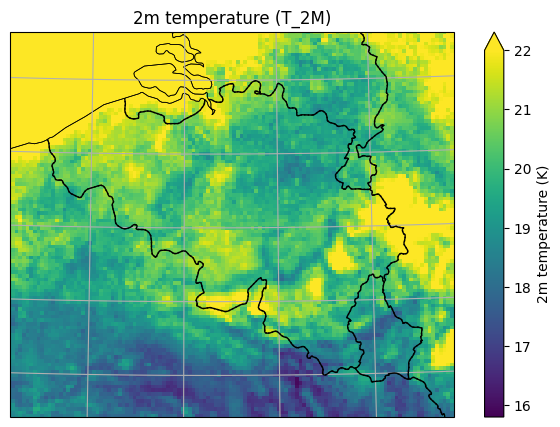

In [20]:
# Create the plot
fig, ax = plt.subplots(subplot_kw={'projection': rp}, figsize = (8,5))
plot_map(plot_data, cmap = "viridis", ax = ax, vmax = 22)
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle="-", color = "black", linewidth = 1, zorder = 100, transform = rp)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color="k", transform = rp)
ax.gridlines()
ax.set_extent([2.2, 6.8, 49.2, 51.8], crs  = ccrs.PlateCarree())


In [14]:
data = xr.open_mfdataset('/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/hourly/T_2M_hourly_20190725.nc', combine='by_coords')

In [15]:
#data_plot = data.where(data.time ==  pd.to_datetime('2019-07-25T16:00:00.000000000'), drop = True)

In [16]:
#data_plot

In [17]:
# plot_data.rio.write_crs(rp.to_string(), inplace = True)
# plot_data = plot_data.rio.reproject("epsg:3857")
# #plot_data.rio.to_raster(ucl_dir + 'CCLM_HW_mean_diff.tif', tiled = True, driver="GTiff")
# plot_data.rio.to_raster("/data/leuven/351/vsc35191/WP3/" + 'CCLM_2019072516h.tif', tiled = True, driver="GTiff")

## 3. Export to GEOTIFF

In [18]:
# driver = gdal.GetDriverByName("GTiff")
# gt = handle.GetGeoTransform()
# proj = handle.GetProjection()


# geotiff_path=f'/test/test.tif'
# outdata = driver.Create(geotiff_path, rows, cols, 1, gdal.GDT_Float32,options = [ 'COMPRESS=DEFLATE','TILED=YES' ])
# outdata.SetGeoTransform(gt)
# outdata.SetProjection(proj)
# outdata.GetRasterBand(1).WriteArray(cclm_var.values)
# outdata.GetRasterBand(1).SetNoDataValue(-9999)
# outdata.FlushCache() ##saves to disk!!
# outdata = None
